# MECA653 LEARN Practical Work
## Creating a simple beauty detector from an existing dataset
Please keep in mind that this is a not so ethical use of Machine Learning.  
Don't be evil.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/15nv00XlXtRHM5dJ-usCQGXJwITFeDuVo?usp=sharing)

_Hints: https://github.com/ustcqidi/BeautyPredict_

# Problem statement

We will have a webcam input. How could we compute a beauty score?  

How to learn what is beauty?

Let's use Convolutional Neural Networks.

In [ ]:
# Fix tensorflow without GPU :(  old cuda-10 but cuda-11.2 mismatch
# 1. Install miniconda
# 2. Install cuda-toolkit 11.2
# 3. Install cudnn 8.1
# 4. Install tensorflow-gpu

# !wget -nc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !bash Miniconda3-latest-Linux-x86_64.sh -b -u
# !$HOME/miniconda3/bin/conda init bash
# !conda install cudatoolkit=11.2 -c conda-forge
# !conda install cudnn=8.1 -c conda-forge
# !python3 -m ipykernel install --user --name=base
# !$HOME/miniconda3/bin/pip3 install ipywidgets matplotlib pandas Pillow scipy tensorflow-gpu  # tf-nightly-gpu

In [2]:
from io import BytesIO
import urllib
from PIL import Image
import IPython
try:
    import ipywidgets as widgets
    from ipywidgets import interact, interact_manual
except ImportError:
    raise ImportError('ipywidgets is not installed.')

@interact
def predict_from_url(URL='https://upload.wikimedia.org/wikipedia/commons/c/c0/Nicolas_Cage_Deauville_2013.jpg'):
    with urllib.request.urlopen(URL) as url:  # Download an image from an URL in RAM memory
        img_size = 128
        img = Image.open(BytesIO(url.read())).convert('RGB')
        img = img.resize((img_size, img_size), Image.BILINEAR)
        IPython.display.display(img)  # Display the image

        # Preprocess image
        # img = tf.keras.preprocessing.image.img_to_array(img)
        # img = preprocess_input(img)
        # img = np.expand_dims(img, axis = 0)
        # prediction = model.predict(img)[0][0]  # Use da model
        # print('Predicted beauty:', prediction)

interactive(children=(Text(value='https://upload.wikimedia.org/wikipedia/commons/c/c0/Nicolas_Cage_Deauville_2…

# 1. Create a dataset
To **train** a neural network, we need a **big** dataset.  
Fortunatly, there is the [SCUT-FBP5500 dataset](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release) by the _Human Computer Intelligent Interaction Lab of South China University of Technology_.

The following script will:  
1.  **Download** the _SCUT-FBP5500.zip_ dataset from GDrive  
2.  Unzip it in _`datasets/SCUT-FBP5500_v2/`_, then delete the original zip file  

In [ ]:
%%capture
![ ! -d 'datasets' ] && echo 'datasets dir not found, will create' && mkdir datasets
![ ! -d 'logs' ] && echo 'logs dir not found, will create' && mkdir logs
![ ! -d 'models' ] && echo 'models dir not found, will create' && mkdir 'models'
![ ! -d './datasets/SCUT-FBP5500_v2' ] && echo './datasets/SCUT-FBP5500_v2 not found, will download & unzip it' && wget https://raw.githubusercontent.com/circulosmeos/gdown.pl/master/gdown.pl && perl gdown.pl 'https://drive.google.com/file/d/1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf' './datasets/SCUT-FBP5500_v2.1.zip' && unzip -n -q -d './datasets/' './datasets/SCUT-FBP5500_v2.1.zip' && rm -f datasets/SCUT-FBP5500_v2.1.zip

We will now define some path variable to easily access the dataset:

In [3]:
import os

dataset_path = os.path.relpath("datasets/SCUT-FBP5500_v2")
txt_file_path = os.path.join(dataset_path, "train_test_files", "All_labels.txt")
images_path = os.path.join(dataset_path, "Images")

assert os.path.exists(dataset_path)
assert os.path.exists(txt_file_path)
assert os.path.exists(images_path)

print("dataset_path:", dataset_path)
print("txt_file_path:", txt_file_path)
print("images_path:", images_path)

dataset_path: datasets/SCUT-FBP5500_v2
txt_file_path: datasets/SCUT-FBP5500_v2/train_test_files/All_labels.txt
images_path: datasets/SCUT-FBP5500_v2/Images


## 1.1 Explore the dataset
Let's check what is in the _`datasets/SCUT-FBP5500_v2/train_test_files/All_labels.txt`_.

You can look inside manualy by double clicking on it.  
Or you can use _pandas_ to compute some statistics.  
> Remember that we have set the `txt_file_path` variable just before.

In [ ]:
import pandas as pd

# Mean rate by the 60th raters
df = "add your code to read the textfile in 'txt_file_path' with pandas"
# (columns should be names=["filename", "rating"] and the separator between columns should be a space))'

# WARNING: We will use the column names you just define next.
#          By default it's set to "filename" and "rating".

# Next are some useful exploratory statistics:

# Check the 5th first row
# df.head()

# Describe the dataset
# df.describe()

# Rates histogram
# df.rating.hist(bins=30, density=1)

<h1><font color=blue>Question</font></h1>What is the average rating?

---

<h1><font color=blue>Question</font></h1>What is the rating range?

- Minimum rate
- Maximum rate

---

# 2. Define a Convolutional Neural Network

We want to use a neural network to infer a score from an image.  
We will first need to define the neural network, then train it, and finally use it.  

## 2.1. Create a dataset loader

To train a neural networks, we need to present it many images as input.  

The dataset loader will open images, preprocess them and send them to the GPU memory.  
It will do this per batch of images.  
The dataset loader works on the CPU, so it could be limited by the CPU.  

In [5]:
import tensorflow as tf
import pkg_resources

for i, gpu in enumerate(tf.config.list_physical_devices('GPU')):
    print('Gpu %d:' % i, gpu)
print()

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Set mixed precision
if pkg_resources.parse_version(tf.__version__)  < pkg_resources.parse_version("2.4.0"):
    tf.keras.mixed_precision.experimental.set_policy("mixed_float16")
    print("Mixed precision policy:", tf.keras.mixed_precision.experimental.global_policy())
else:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision policy:", tf.keras.mixed_precision.global_policy())

Gpu 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
Mixed precision policy: <Policy "mixed_float16">


In [6]:
import numpy as np
import time
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.applications.mobilenet_v3 import MobileNetV3Small, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_size = 128  # This low-resolution to increase speed
batch_size = 128  # This is the number of images per batches

validation_split = 0.2  # 0.2 -> 20% in validation, 80% in train
training_steps_per_epoch = (len(df) * (1 - validation_split)) // batch_size
validation_steps = (len(df) * validation_split) // batch_size


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # This is what modify image color for ImageNet normalization
    validation_split=validation_split,
    fill_mode = 'nearest',
    # rotation_range=30,
    # width_shift_range=0.10,
    # height_shift_range=0.10,
    horizontal_flip=True,
    vertical_flip=False,
    # shear_range=0.05,  # Shear angle in counter-clockwise direction as radians.
    zoom_range=[0.7, 1.2],  # Float [1-value, 1+value] or [lower, upper] of random zoom.
    # brightness_range=[0.5, 1.8]  # Takes 100ms!  Random ratio [lower, upper] of brightness change.
)

train_generator = datagen.flow_from_dataframe(     
    subset='training',
    dataframe=df,  
    directory=images_path,
    x_col='filename', # name of col in data frame that contains file names
    y_col='rating',   # name of col with labels
    batch_size=batch_size,
    shuffle=True,
    target_size=(image_size, image_size),
    class_mode='raw',  # 'raw' is for regression, 'categorical' for classification task
)
validation_generator = datagen.flow_from_dataframe(     
    subset='validation',
    dataframe=df,
    directory=images_path,
    x_col='filename', # name of col in data frame that contains file names
    y_col='rating',   # name of col with labels
    batch_size=batch_size,
    shuffle=True,
    target_size=(image_size, image_size),
    class_mode='raw'  # 'raw' is for regression, 'categorical' for classification task
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_types=(tf.float32, tf.float32),  # int32
    output_shapes=([None, image_size, image_size, 3], [None])  # None instead of a fixed batch_size for variable batch_size
)
validation_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, image_size, image_size, 3], [None])  # None instead of a fixed batch_size for variable batch_size
)

Found 4400 validated image filenames.
Found 1100 validated image filenames.


### 2.2 - Try and optimize the dataset loader

You can now try the dataset loader by computing a batch of images.

Batch generation duration: 0.39s


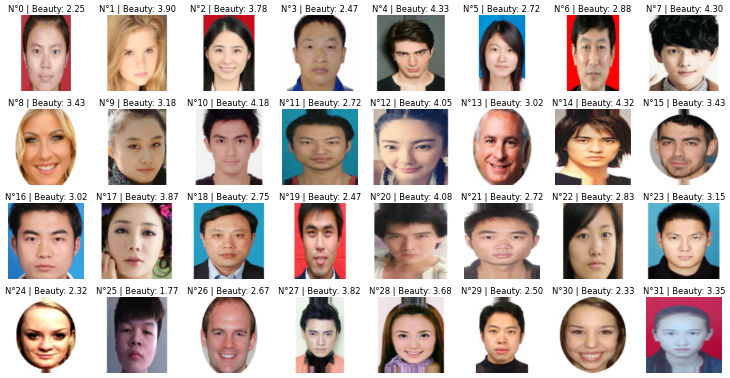

In [7]:
import matplotlib.pyplot as plt


# Display the dataset
train_generator.image_data_generator.preprocessing_function=None  # Remove preprocessing
t1 = time.time()
x_batch, y_batch = next(train_generator)
print("Batch generation duration: %.2fs" % float(time.time()-t1))
train_generator.image_data_generator.preprocessing_function = preprocess_input  # Enable preprocessing

plt.figure(figsize=(12, 8), dpi=50)
plt.subplots_adjust(bottom=0, left=.01, right=1.2, top=0.9, hspace=0.2)
for i, (image, label) in enumerate(zip(x_batch[:32], y_batch[:32])):
    plt.subplot(4, 8, i + 1)
    plt.axis("off")
    plt.imshow(image.astype(np.uint8))
    plt.title("N°%i | Beauty: %.2f" % (i, label))

You can see that the images have been modified: deformation, luminosity, contrast.  

This is called **Data Augmentation**.  

The main idea is to artificialy increase the diversity of the dataset by transforming the data before using it for training.  
These transformations are done on the CPU and can be computational heavy.  

<h1><font color=blue>Question</font></h1> Can you choose better augmentation parameters?

---

## 2.3. Define a Neural Network

We will use **transfer learning**.  

Transfer learning means that we use a **pre-trained model**, but removed the pre-trained **last** layer.  

1. We add our custom last layer **on top** of the pre-trained model  
2. Then we only train our last custom layer  
3. Finally we can fine-tune the full model

It is important to choose a good last layer *architecture*.  

You could **hand-tune** this, or use **AutoML** (bayesian/genetic search).  

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam


learning_rate = 0.001


def create_model():
    # Create a new neural networks model.
    model = Sequential(name='beautyNet')

    # Add a pre-trained model, without the last layer
    model.add(
        MobileNetV2(
            include_top=False,
            input_shape=(image_size, image_size, 3),
            pooling='avg',
            weights='imagenet')
    )

    # 1st layer as Dense with ReLu
    model.add(Dense(2, activation='relu'))

    # Add a stochastic regularization to avoid overfitting
    model.add(Dropout(rate=0.1))

    # Last layer as Dense for regression
    model.add(Dense(1, activation='linear'))

    # Do not train the first layer model, as it is already pre-trained
    model.layers[0].trainable = False

    # Compile the model with an optimizer
    model.compile(
        loss='mean_squared_error',  # 'mean_absolute_error', 'kullback_leibler_divergence'
        optimizer=Adam(learning_rate=learning_rate)
    )
    return model


model = create_model()
model.summary()

Model: "beautyNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,268,241
Trainable params: 10,257
Non-trainable params: 2,257,984
_________________________________________________________________


## 3. Train the neural networks

We will use **transfer learning**.  

Transfer learning means that we use a **pre-trained model**, but removed the pre-trained **last** layer.  

1. We add our custom last layer **on top** of the pre-trained model  
2. Then we only train our last custom layer  
3. Finally we can fine-tune the full model

It is important to choose a good last layer *architecture*.  

You could **hand-tune** the model architecture and hyperparameters, or use **AutoML** (bayesian/genetic search).  

In [9]:
import multiprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


n_epochs = 20
initial_epoch = 0


callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-3,
        patience=10,
        verbose=1,
        ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        cooldown=1,
        min_lr=0.00001
        ),
    ModelCheckpoint(
        filepath='beauty_model_untuned_epoch{epoch:02d}.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
        )
]

t_start = time.time()
history = model.fit(
    train_dataset,
    epochs=n_epochs,
    callbacks=callbacks,
    initial_epoch=initial_epoch,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    workers=multiprocessing.cpu_count(),
)

print('Training duration: %.2fs' % float(time.time()-t_start))

Epoch 1/20
34/34 [==============================] - 35s 750ms/step - loss: 6.7363 - val_loss: 0.7023

Epoch 00001: val_loss improved from inf to 0.70233, saving model to beauty_model_untuned_epoch01.h5
Epoch 2/20
34/34 [==============================] - 17s 513ms/step - loss: 1.0485 - val_loss: 0.4525

Epoch 00002: val_loss improved from 0.70233 to 0.45248, saving model to beauty_model_untuned_epoch02.h5
Epoch 3/20
34/34 [==============================] - 17s 514ms/step - loss: 0.8943 - val_loss: 0.4391

Epoch 00003: val_loss improved from 0.45248 to 0.43915, saving model to beauty_model_untuned_epoch03.h5
Epoch 4/20
34/34 [==============================] - 17s 514ms/step - loss: 0.8333 - val_loss: 0.3691

Epoch 00004: val_loss improved from 0.43915 to 0.36914, saving model to beauty_model_untuned_epoch04.h5
Epoch 5/20
34/34 [==============================] - 17s 507ms/step - loss: 0.8411 - val_loss: 0.3352

Epoch 00005: val_loss improved from 0.36914 to 0.33523, saving model to beauty

In [20]:
# Evaluate (WARNING: you should use normaly unseen data)
test_loss = model.evaluate(train_generator, verbose=1)
print('Test loss: {:0.2f}'.format(test_loss))

35/35 [==============================] - 14s 396ms/step - loss: 0.2630
Test loss: 0.26


You can now save the final model.

## 4. Save / load the trained model

In [ ]:
# Load a model from local checkpoints
epoch_id = 20

model_loaded = tf.keras.models.load_model('beauty_model_untuned_epoch%d.h5' % epoch_id)

In [10]:
# Save the final model
models_path = os.path.relpath("models")
assert os.path.exists(models_path)

# Save the final model
model.save(os.path.join(models_path, "beauty_model_untuned"))  # creates a HDF5 file 'final_beauty_model.h5'

INFO:tensorflow:Assets written to: models/beauty_model_untuned/assets


In [ ]:
import os
import tensorflow as tf

# Load the final model
models_path = os.path.relpath("models")

model_loaded = tf.keras.models.load_model(os.path.join(models_path, "beauty_model_untuned"))

## 5. Use your model

In [24]:
# Predict on a new image
from io import BytesIO
import urllib
from PIL import Image
import IPython
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


@interact
def predict_from_url(URL='https://upload.wikimedia.org/wikipedia/commons/c/c0/Nicolas_Cage_Deauville_2013.jpg'):
    with urllib.request.urlopen(URL) as url:  # Download an image from an URL in RAM memory
        img_size = 128
        img = Image.open(BytesIO(url.read())).convert('RGB')
        img = img.resize((img_size, img_size), Image.BILINEAR)

        # Preprocess image
        img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert PIL image to np.array
        img_batch = np.expand_dims(img_array, axis=0)  # Add a batch dim
        img_preprocessed = preprocess_input(img_batch)  # Normalize
        y_predicted = model.predict(img_preprocessed)  # Predict with your model

        IPython.display.display(img)  # Display the image
        print("Predicted beauty score:", y_predicted.flatten())

interactive(children=(Text(value='https://upload.wikimedia.org/wikipedia/commons/c/c0/Nicolas_Cage_Deauville_2…

## 6. Run your model locally in a simple webapp

We can convert the Keras model into TensorFlow.js format using the Python package `tensorflowjs`.

Read more about [converting Keras models to tfjs](https://js.tensorflow.org/tutorials/import-keras.html).

The following script will convert your model to tfjs, then create a zip file.  
To run the demo locally in your web browser, you will have to execute a **web server** in the `live_demo` folder.

In [26]:
!$HOME/miniconda3/bin/pip3 install -q tensorflowjs

In [28]:
import tensorflowjs as tfjs

tf.keras.backend.clear_session()  # Clean up variable names before exporting

# Convert model
model = tf.keras.models.load_model(os.path.join(models_path, "beauty_model_untuned"))
tfjs.converters.save_keras_model(model, "live_demo/model/",
                                 quantization_dtype_map={"uint8": "*"})

# Write an index.html file
with open('live_demo/index.html', 'w') as f:
  f.write('''
        <!DOCTYPE html>
        <html lang="en">
        <head>
          <meta charset="UTF-8" />
          <meta name="viewport" content="width=device-width, initial-scale=1.0" />
          <script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@latest"></script>
          <script src="https://cdn.jsdelivr.net/npm/@tensorflow-models/mobilenet"></script>
          <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/semantic-ui@2.4.2/dist/semantic.min.css" />
          <script src="https://cdn.jsdelivr.net/npm/semantic-ui@2.4.2/dist/semantic.min.js"></script>
          <style type="text/css">
            .app_container {
              width: 500px;
              display: flex;
              flex-direction: column;
              justify-content: center;
              align-items: center;}
            .ui .card {width: 90vw !important;}

            .content {
              display: flex;
              flex-direction: column;
            }

            .button_container {
              display: flex;
              flex-direction: row;
              justify-content: space-around;
              margin: 15px;
            }

            #output {
              font-size: 2em !important;
            }

            body {
              background-color: linen;
            }

            .stream {
              display: flex;
              overflow: hidden;
            }

            .card {
              min-width: 320px;
            }
          </style>

          <title>BeautyNet</title>
        </head>

        <body>
          <div class="ui one column centered grid" style="margin: 20px 0">
            <div class="app_container">
              <h1>BeautyNet</h1>
              <div class="ui card">
                <div class="stream">
                  <video width="100%" height="100%" autoplay playsinline muted id="webcam"></video>
                </div>
                <div class="content" id="content">
                  <div class="button_container">
                    <button class="ui primary button" id="capture">Save</button>
                    <button class="ui button" id="stop">Stop</button>
                  </div>
                  <div class="ui sub header" id="output"></div>
                </div>
              </div>
            </div>
          </div>
          <script>
            const modelPath = './model/model.json';
            const imageSize = 128;
            const predictionInterval = 500;
            var webcamElement = document.getElementById("webcam");
            var output = document.getElementById("output");
            var captureButton = document.getElementById("capture");
            var stopButton = document.getElementById("stop");
            var stopped = false;
            let model = null;

            async function setupWebcam() {
              return new Promise((resolve, reject) => {
                const navigatorAny = navigator;
                navigator.getUserMedia = navigator.getUserMedia ||
                  navigatorAny.webkitGetUserMedia || navigatorAny.mozGetUserMedia ||
                  navigatorAny.msGetUserMedia;
                if (navigator.getUserMedia) {
                  navigator.getUserMedia({
                      video: true
                    },
                    stream => {
                      webcamElement.srcObject = stream;
                      webcamElement.addEventListener("loadeddata", resolve, false);
                    },
                    error => reject());
                } else {
                  reject();
                }
              });
            }

            async function predictImage() {
              const img = await getWebcamImage();
              let result = tf.tidy(() => {
                const input = img.reshape([1, imageSize, imageSize, 3]);
                return model.predict(input);
              });
              img.dispose(); // Dispose the tensor to release the memory.
              let prediction = await result.data();
              result.dispose(); // Dispose the tensor to release the memory.
              output.innerText = `score: ${(prediction[0]).toFixed(1)}\n`;
            }

            async function getWebcamImage() {
              const img = (await webcam.capture()).toFloat();
              const normalized = img.div(127).sub(1);
              return normalized;
            }

            let webcam = null;
            let predictInterval;
            (async () => {
              // Load the model
              tf.loadLayersModel(modelPath)
                .then(response => {
                  model = response;
                  console.log("Model successfully loaded!");
                })
                .catch(error => output.textContent = "ERROR :" + error.message +
                  " Fix: put your model in a ./model/ folder")

              await setupWebcam();
              webcam = await tf.data.webcam(webcamElement, {
                resizeWidth: imageSize,
                resizeHeight: imageSize,
              });

              // Setup prediction every 500 ms
              predictInterval = setInterval(predictImage, predictionInterval);
            })();

            captureButton.addEventListener("click", async function () {
              const img = await getWebcamImage();
              let result = tf.tidy(() => {
                const input = img.reshape([1, imageSize, imageSize, 3]);
                return model.predict(input);
              });
              img.dispose(); // Dispose the tensor to release the memory.
              let prediction = await result.data();
              result.dispose(); // Dispose the tensor to release the memory.
              console.log("score", prediction[0]);
              output.innerText = `score: ${(prediction[0]).toFixed(1)}\n`;

              const div = document.createElement('div');
              div.innerText = `score: ${(prediction[0]).toFixed(3)}\n`;
              div.className = "description";
              document.getElementById("content").appendChild(div);
            });

            stopButton.addEventListener("click", function () {
              if (stopped == false) {
                clearInterval(predictInterval);

                stream = webcamElement.srcObject;
                tracks = stream.getTracks();
                tracks.forEach(function (track) {
                  track.stop();
                });
                stopButton.innerText = "Restart";
                stopped = true;
                console.log("Stop prediction");
              } else {
                (async () => {
                  await setupWebcam();
                  webcam = await tf.data.webcam(webcamElement, {
                    resizeWidth: imageSize,
                    resizeHeight: imageSize,
                  });
                  predictInterval = setInterval(predictImage, predictionInterval);
                  stopButton.innerText = "Stop";
                  stopped = false;
                  console.log("Prediction restarted");
                })();
              }
            });
          </script>
        </body>
        </html>
        ''')

!zip -r live_demo.zip live_demo

from IPython.display import FileLink
FileLink("live_demo.zip")

updating: live_demo/ (stored 0%)
updating: live_demo/index.html (deflated 63%)
updating: live_demo/model/ (stored 0%)
updating: live_demo/model/model.json (deflated 92%)
updating: live_demo/model/group1-shard1of1.bin (deflated 19%)


/home/elmokulc/live_demo.zip

## 7. Ideas to improve

In [ ]:
!$HOME/miniconda3/bin/pip3 install -U tensorflow-addons

Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.7/dist-packages (0.12.1)


In [ ]:
import datetime
import psutil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa


# Cache dataset to RAM (WARNING: could OOM)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# Trace memory usage
class MemoryCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    bts = process.memory_info().rss  # in bytes
    # vbts = psutil.virtual_memory().used  # in bytes
    print(' RAM:', (bts / 1024) // 1024, 'MB')


process = psutil.Process(os.getpid())


# More epochs
n_epochs = 20


# Change learning rate over time
cyclic_rate_schelduler = tfa.optimizers.cyclical_learning_rate.Triangular2CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=0.005,
    # step_size=4 * training_steps_per_epoch,
    step_size=training_steps_per_epoch // 2,
    # scale_fn=lambda x: 1.,
    scale_mode='cycle',
    name='Triangular2CyclicalScheduler'
)

# Better optimizer
radam = tfa.optimizers.RectifiedAdam(learning_rate=cyclic_rate_schelduler)
ranger = tfa.optimizers.Lookahead(radam)

# Better loss
model.compile(optimizer=ranger, loss='mean_absolute_error')  # 'mean_absolute_percentage_error', 'mean_squared_error', 'kullback_leibler_divergence'

In [ ]:
# Train with all these new things
t_start = time.time()
history = model.fit(
    train_dataset,
    epochs=n_epochs,
    callbacks=[*callbacks, MemoryCallback()],
    initial_epoch=initial_epoch,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    workers=multiprocessing.cpu_count(),
)

print("Training duration: %.2fs" % float(time.time()-t_start))

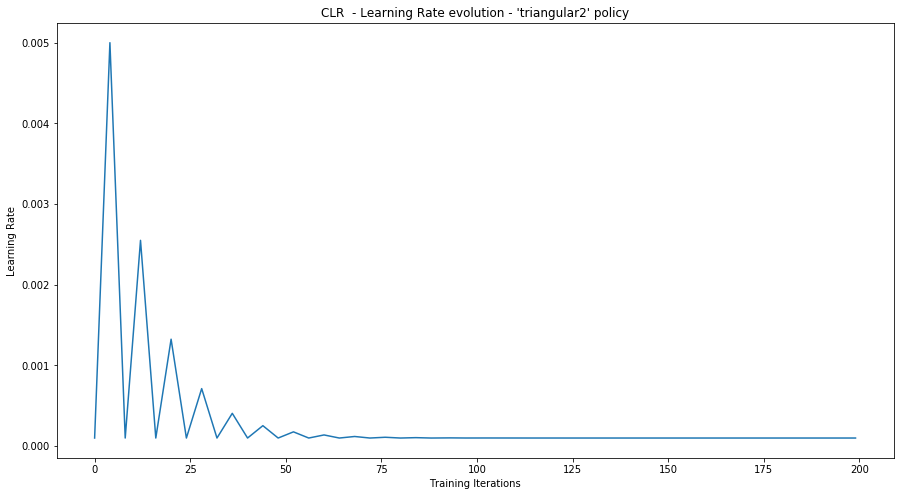

In [ ]:
# View the learning rate evolution during training
plt.figure(1, figsize=(15, 8)) 
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.title("CLR  - Learning Rate evolution - 'triangular2' policy")
plt.plot(range(0, n_epochs), [cyclic_rate_schelduler(i) for i in range(0, n_epochs)])
plt.show()

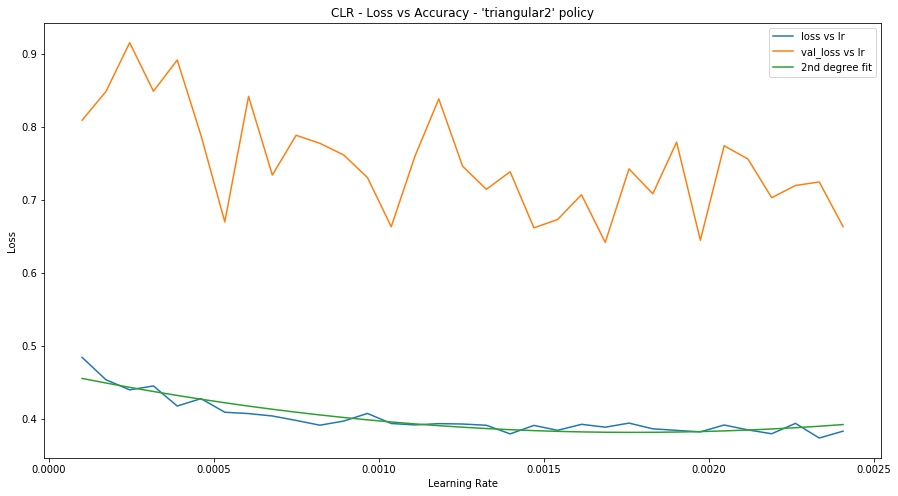

In [ ]:
# View the learning rate evolution during training regarding the loss
plt.figure(1, figsize=(15, 8)) 
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("CLR - Loss vs Accuracy - 'triangular2' policy")
plt.plot([cyclic_rate_schelduler(i) for i in model.history.epoch], model.history.history["loss"])
plt.plot([cyclic_rate_schelduler(i) for i in model.history.epoch], model.history.history["val_loss"])

z = np.polyfit([cyclic_rate_schelduler(i) for i in model.history.epoch], model.history.history["loss"], 2)
p = np.poly1d(z)
plt.plot([cyclic_rate_schelduler(i) for i in model.history.epoch], p([cyclic_rate_schelduler(i) for i in model.history.epoch]))
plt.legend(["loss vs lr", "val_loss vs lr", "2nd degree fit"]) 

plt.show()

### Benchmark the dataloader

In [ ]:
# Benchmark your dataloader
import time


def benchmark(dataset, num_epochs=1, num_iter=100):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for iter_num, sample in enumerate(dataset):
            if iter_num > 100:
                print("break")
                break
            pass  # Performing a training step
    tf.print("Dataloader time per iter:", (time.perf_counter() - start_time) / (num_epochs * iter_num) )

benchmark(train_dataset)